In [1]:
import wandb
api = wandb.Api()


In [2]:
import numpy as np
# Define the project name and IDs

project_name = "crwhite/lowprecision"
ids = {
    'Baseline+modes32': 'mr87rkwo',
    'AMP+HP+tanh+modes32': 'fkdtpzhn',
    'Baseline+modes16': 'a3s5fzkq',
    'AMP+HP+tanh+modes16': '1k09jf3m'
}

ids_seed2 = {
    'Baseline+modes32': 'auwfe50m',
    'AMP+HP+tanh+modes32': 'p1n0y95s',
    'Baseline+modes16': '5uwi86tj',
    'AMP+HP+tanh+modes16': 'plf86x9a'
}


# Define the metrics to extract
metrics = ["time", "128_h1"]

# Create dictionaries to store the data
data_time = {}
data_128_h1 = {}
data_128_h1_seed2 = {}

# Loop through the methods and extract the metrics
for method, exp_id in ids.items():
    # Access the W&B run
    run = wandb.Api().run(f"{project_name}/{exp_id}")

    # Get the history for the run
    history = run.history()

    # Extract the metrics data
    time_data = history[metrics[0]]
    h1_data = history[metrics[1]]

    # Store the data in the dictionaries
    data_time[method] = np.array(time_data)
    data_128_h1[method] = np.array(h1_data)

for method, exp_id in ids_seed2.items():
    # Access the W&B run
    run = wandb.Api().run(f"{project_name}/{exp_id}")

    # Get the history for the run
    history = run.history()

    # Extract the metrics data
    time_data = history[metrics[0]]
    h1_data = history[metrics[1]]

    # Store the data in the dictionaries
    data_128_h1_seed2[method] = np.array(h1_data)


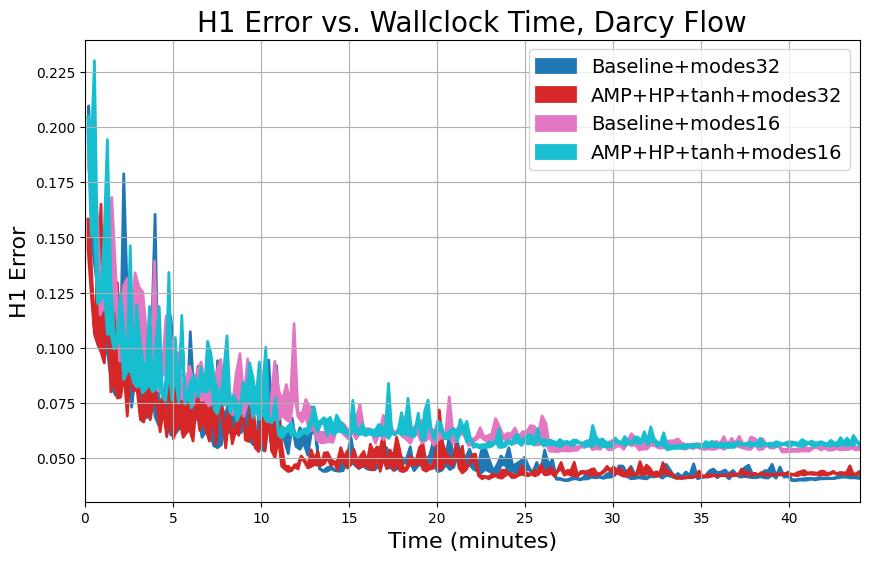

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
def plot_training_curves(data_time, data_losses, data_losses2, methods):
    plt.figure(figsize=(10, 6))

    x = np.arange(len(methods))
    colors = plt.cm.get_cmap('tab10', len(methods))
    line_styles = ['-', '-', '-', '-']
    markers = ['o', 's', '^', 'x']
    line_widths = [2]*4
    #alphas = [0.8, 1.0, 0.8, 0.7]

    for i, method in enumerate(methods):        
        time = data_time[method]
        losses = data_losses[method]

        losses_seed2 = data_losses2[method]
        max_errors = np.maximum(losses, losses_seed2)
        min_errors = np.minimum(losses, losses_seed2)
        
        cumulative_time = np.nancumsum(time) / 60  # Calculate cumulative time
        #plt.plot(cumulative_time, losses, label=method,  color=colors[i], linestyle=line_styles[i], linewidth=line_widths[i], alpha=alphas[i])
        plt.fill_between(cumulative_time, min_errors, max_errors, label=method,  color=colors(i), linestyle=line_styles[i], linewidth=line_widths[i])


    
    plt.xlabel('Time (minutes)', fontsize=16)
    plt.xlim([0, 44])
    plt.ylabel('H1 Error', fontsize=16)
    plt.title('H1 Error vs. Wallclock Time, Darcy Flow', fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.savefig('error_vs_time_darcy.pdf', format='pdf')
    plt.show()


methods = ids.keys()

plot_training_curves(data_time, data_128_h1, data_128_h1_seed2, methods)


In [4]:


def plot_pareto_curve(training_time, loss, methods):
    plt.figure(figsize=(8, 6))

    # Plot the data points
    plt.scatter(training_time, loss)
    # Find the leftmost, bottom-most, and additional point
    leftmost_idx = np.argmin(training_time)
    bottommost_idx = np.argmin(loss)
    #additional_idx = np.where((training_time < training_time[leftmost_idx]) & (loss < loss[bottommost_idx]))[0]
    additional_idx = 5
    additional_idx_1 = 6
    additional_idx_2 = 7

    # Plot the leftmost, bottom-most, and additional points
    #plt.scatter(training_time[leftmost_idx], loss[leftmost_idx], color='red')
    #plt.scatter(training_time[bottommost_idx], loss[bottommost_idx], color='green')
    #plt.scatter(training_time[additional_idx], loss[additional_idx], color='orange')

    # Connect the points in the Pareto curve
    pareto_points = np.array([[training_time[leftmost_idx], loss[leftmost_idx]],
                              [training_time[bottommost_idx], loss[bottommost_idx]],
                              [training_time[additional_idx], loss[additional_idx]],
                              [training_time[additional_idx_1], loss[additional_idx_1]],
                              [training_time[additional_idx_2], loss[additional_idx_2]]])
    pareto_points = pareto_points[np.argsort(pareto_points[:, 0])]
    plt.plot(pareto_points[:, 0], pareto_points[:, 1], color='black', label='Pareto Curve')

    # Create a dictionary to map each unique method to a color and a legend handle
    method_legend_handles = {}
    
    # Plot the data points with the same color and legend handle for the same method
    for i, method in enumerate(methods):
        if method not in method_legend_handles:
            color = plt.cm.tab10(len(method_legend_handles))
            legend_handle = plt.scatter([], [], color=color, label=method)
            method_legend_handles[method] = legend_handle
        plt.scatter(training_time[i], loss[i], color=method_legend_handles[method].get_facecolor()[0])
    
    
    plt.xlabel('Training Time', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('H1 Loss vs. Runtime, Darcy Flow', fontsize=20)
    # Create a shared legend for data points with the same method
    legend_handles = [method_legend_handles[method] for method in method_legend_handles]
    plt.legend(handles=legend_handles, fontsize=14) #, loc='upper right')
    
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('pareto_curve_v100_darcy.pdf', format='pdf')
    plt.show()



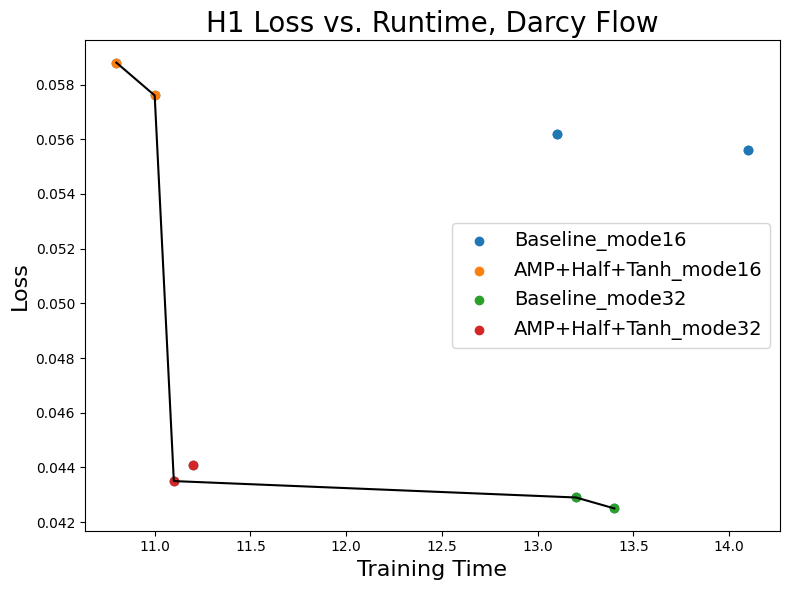

In [5]:

# these are the numbers for Navier stokes on v100
#training_time = [38.7, 28.1, 43.4, 31.6, 38.6, 28.1, 43.4, 31.6]
#loss = [0.0195, 0.0213, 0.0172, 0.0195, 0.0188, 0.0208, 0.0171, 0.0192 ]

# these are the numbers for Darcy flow on v100
training_time = [13.1, 10.8, 13.4, 11.2, 14.1, 11.0, 13.2, 11.1]
loss = [.0562, .0588, .0425, .0441, .0556, .0576, .0429, .0435]


methods = ['Baseline_mode16', 'AMP+Half+Tanh_mode16', 'Baseline_mode32', 'AMP+Half+Tanh_mode32']
methods.extend(methods)

plot_pareto_curve(training_time, loss, methods)